In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import spatial_metrics.helper_functions as hf
import spatial_metrics.spatial_metrics_calcium_binarized_base as sm
import spatial_metrics.bootstrapped_estimation as be



In [2]:
# fazer um loader para dados genericos
from spatial_metrics.data_loader import LoadData
from spatial_metrics.data_processing import ProcessData


In [3]:
# Initialize loader
loader = LoadData('kinsky')

# See what's available
# loader.list_available()
loader.show_jupyter_tree()


Dataset path resolved: /home/apolo/Documents/github_projects/information_metrics/tutorial/data/kinsky


In [4]:

# Load specific dataset
data = loader.load(mouse_id=1, day=1, session=1)
data


{'position': {'x': array([33.31549965, 33.68112613, 33.87063125, ..., 31.16963385,
         30.92036124, 30.71436074], shape=(12341,)),
  'y': array([53.24076999, 53.44182864, 53.44689017, ..., 42.53673027,
         42.20114903, 41.8824232 ], shape=(12341,)),
  'time': array([ 16.3 ,  16.35,  16.4 , ..., 633.2 , 633.25, 633.3 ],
        shape=(12341,))},
 'traces': {'raw': array([[-1.5893332e-03, -2.1475016e-03, -2.3348499e-03, ...,
           7.3202150e-03,  6.1626555e-03,  6.5705916e-03],
         [-5.5961423e-03, -3.9062107e-03, -4.2496477e-03, ...,
          -1.5494933e-03, -3.0333218e-03, -2.4431562e-03],
         [-5.3208605e-03, -3.0862184e-03, -5.0647734e-03, ...,
          -9.8666633e-03, -7.8982897e-03, -8.5074883e-03],
         ...,
         [-7.5973622e-03, -6.5999418e-03, -6.8442142e-03, ...,
           8.8632223e-04,  2.4203248e-03,  2.8515742e-03],
         [ 3.6098133e-04, -7.1392598e-04,  8.5577049e-05, ...,
          -3.3039865e-03, -1.8775027e-03, -1.7858761e-03],
  

In [5]:
x_coordinates = data['position']['x'].copy()
y_coordinates = data['position']['y'].copy()
time_vector = data['position']['time'].copy()
sampling_rate = data['sampling_rate']


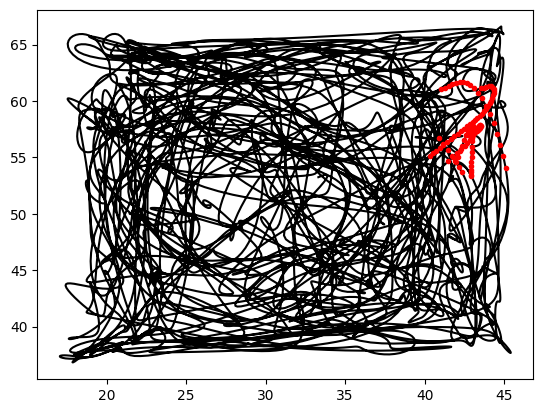

In [6]:
# plot your data to set environment_edges

# cell = 1
cell = 49
input_signal = data['traces']['binary'][cell,:].copy()

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[input_signal==1],y_coordinates[input_signal==1],'r.')
plt.show()


In [7]:
# You should first set your environment edges. You can think of it as a retangular box in cm.
# environment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]
# if you don`t set it, the program will use min and max coordinates as edges.

environment_edges = [[10,50],[20,70]]
# data_info = ProcessData(input_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)
data_info = ProcessData(input_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)
data_info.environment_edges


[[10, 50], [20, 70]]

In [8]:
# Arguments taken from the paper "Hippocampal Place Fields Maintain a Coherent and
# Flexible Map across Long Timescales"

signal_type = 'binarized'

# Create a dictionary to hold input parameters for further processing
input_dict = dict()
# Construct the filename and other identifiers for saving the results
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type  # Prefix for the filename
input_dict['animal_id'] = 'NeuronModel'  # Identifier for the animal or model
input_dict['dataset'] = 'Simulation'  # Name of the dataset
input_dict['day'] = 1  # Day or session number
input_dict['neuron'] = 1  # Neuron identifier
input_dict['trial'] = None  # Trial identifier (optional, can be None)
input_dict['saving_path'] = None  # Directory path for saving results (optional, can be None)
input_dict['saving'] = False  # Flag indicating whether to save the results (False means no saving)
input_dict['signal_type'] = signal_type  

# Set inclusion criteria for the analysis
input_dict['min_time_spent'] = 0  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
input_dict['min_visits'] = 0  # Minimum number of visits required in each xy bin
input_dict['min_speed_threshold'] = 0  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
input_dict['speed_smoothing_sigma'] = 0.5  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and spatial information calculation
input_dict['x_bin_size'] = 1  # Size of x bins (in coordinate units [e.g., cm, pixels])
input_dict['y_bin_size'] = 1  # Size of y bins (in coordinate units [e.g., cm, pixels])
input_dict['map_smoothing_sigma_x'] = 2.5  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
input_dict['map_smoothing_sigma_y'] = 2.5 # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for surrogate analysis
input_dict['shift_time'] = 200  # Time shift window in seconds for creating surrogate distributions
input_dict['num_cores'] = -1  # Number of CPU cores to use (set to -1 to use all available cores)
input_dict['num_surrogates'] = 800  # Number of surrogate distributions to generate

# Set parameters for place fields detection
input_dict['min_num_of_bins'] = 2  # Minimum number of xy-bins required to define a place field

input_dict['field_detection_method'] = 'std_from_field'  # place field detection method (std_from_field or random_fields)
input_dict['percentile_threshold'] = 99  # Percentile threshold for determining place field boundaries when field_detection_method = 'random_fields'
input_dict['detection_threshold'] = 1 # place field detection threshold in std when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_sigma_x'] = 2.5  # Gaussian 2D std of the smoothing area in coordinate units for detecting place fields when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_sigma_y'] = 2.5  # Gaussian 2D std of the smoothing area in coordinate units for detecting place fields when field_detection_method = 'std_from_field'

input_dict['alpha'] = 0.05 # alpha on the decision if a cell can be classified as a place cell 

spatial_metrics = sm.PlaceCellBinarized(**input_dict)
spatial_metrics_output = spatial_metrics.main(data_info)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

SpatialMetrics.binarized.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


In [10]:
data_info.environment_edges

[[10, 50], [20, 70]]

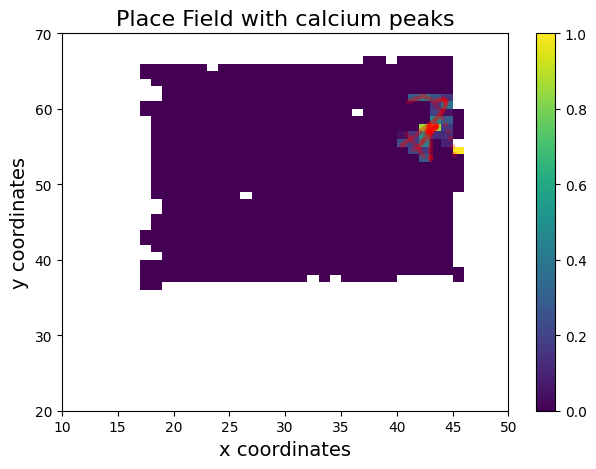

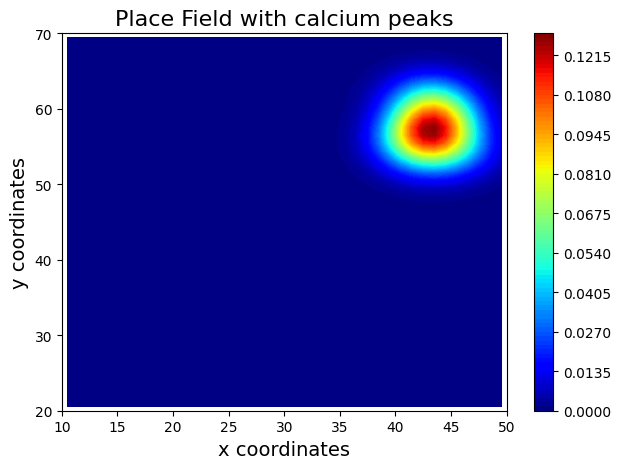

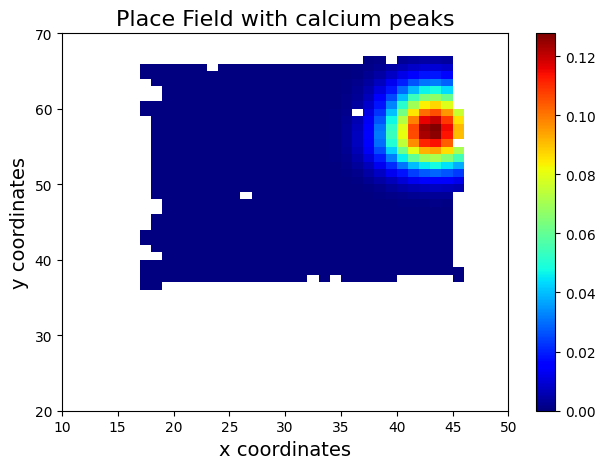

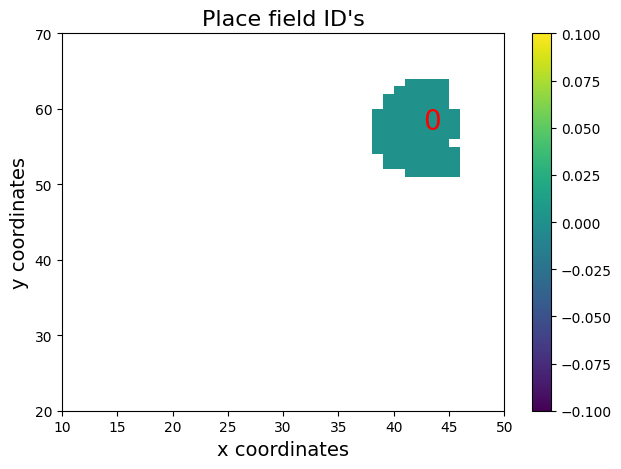

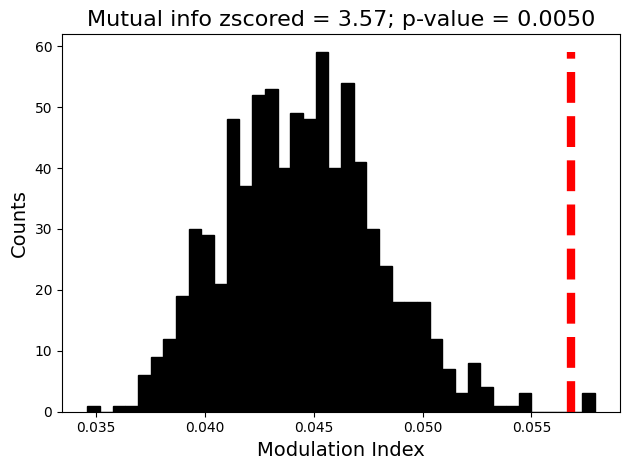

In [11]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors=None)
plt.colorbar()
plt.plot(spatial_metrics_output['peaks_x_location'],spatial_metrics_output['peaks_y_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)

plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([data_info.environment_edges[0][0],data_info.environment_edges[0][1]])
plt.ylim([data_info.environment_edges[1][0],data_info.environment_edges[1][1]])
plt.tight_layout()
plt.show()


plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'],100,cmap='jet')
# plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([data_info.environment_edges[0][0],data_info.environment_edges[0][1]])
plt.ylim([data_info.environment_edges[1][0],data_info.environment_edges[1][1]])
plt.tight_layout()
plt.show()



nan_mask = np.isnan(spatial_metrics_output['activity_map'])
activity_map_smoothed = spatial_metrics_output['activity_map_smoothed'].copy()
activity_map_smoothed[nan_mask] = np.nan
plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],activity_map_smoothed,edgecolors=None,cmap='jet')
# plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([data_info.environment_edges[0][0],data_info.environment_edges[0][1]])
plt.ylim([data_info.environment_edges[1][0],data_info.environment_edges[1][1]])
plt.tight_layout()
plt.show()



place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_identity'])
plt.colorbar()

for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([data_info.environment_edges[0][0],data_info.environment_edges[0][1]])
plt.ylim([data_info.environment_edges[1][0],data_info.environment_edges[1][1]])
plt.tight_layout()
plt.show()

# statistic = be.calculate_p_value(spatial_metrics_output['mutual_info_original'], spatial_metrics_output['mutual_info_shifted'], alternative='greater')
p_value = spatial_metrics_output['mutual_information_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_shifted'],40)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_original'],spatial_metrics_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.4f}".format(spatial_metrics_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
# Place field extension relative to the whole enviroment
spatial_metrics_output['place_cell_extension_absolute']


array([0.0435])

In [13]:

# Place field extension relative to enviroment occupancy
spatial_metrics_output['place_cell_extension_relative']


array([0.10902256])

In [87]:
num_of_islands_pre = np.unique(activity_map_identity)[1:].shape[0]
num_of_islands_pre

1

In [88]:
np.unique(activity_map_identity)

array([0., 1.])

In [90]:


island_counter = 0
for ii in range(1, num_of_islands_pre + 1):
    if np.where(activity_map_identity == ii)[0].shape[0] > min_num_of_bins:
        island_counter += 1
    else:
        activity_map_identity[np.where(activity_map_identity == ii)] = 0

num_of_islands = island_counter

islands_id = np.unique(activity_map_identity)[1:]
islands_y_com = []
islands_x_com = []
pixels_above = []

for ii in islands_id:
    # Create a mask for the current island
    island_mask = (activity_map_identity == ii)
    
    # Calculate the center of mass for this island
    x_com, y_com = center_of_mass(island_mask, activity_map_smoothed,x_center_bins,y_center_bins)
    
    islands_y_com.append(y_com)
    islands_x_com.append(x_com)

    pixels_above.append(np.nansum(island_mask))

islands_x_com = np.array(islands_x_com)
islands_y_com = np.array(islands_y_com)
pixels_above = np.array(pixels_above)

total_visited_pixels = np.nansum(visits_map != 0)
pixels_total = activity_map_smoothed.shape[0] * activity_map_smoothed.shape[1]

pixels_place_cell_relative = pixels_above / total_visited_pixels
pixels_place_cell_absolute = pixels_above / pixels_total




NameError: name 'center_of_mass' is not defined

In [45]:
spatial_metrics_output.keys()


dict_keys(['activity_map', 'activity_map_smoothed', 'activity_map_shifted', 'activity_map_smoothed_shifted', 'timespent_map', 'visits_map', 'speed_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'peaks_x_location', 'peaks_y_location', 'activity_map_identity', 'num_of_fields', 'fields_x_max', 'fields_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shifted', 'mutual_info_zscored', 'mutual_info_centered', 'input_parameters'])

In [50]:

spatial_metrics_output['fields_y_max']

array([57.35770742,         nan])

In [ ]:
# Cells from fig 2C are 49,127,211,267 from
# data_dir = f"{project_root}/data/Kinsky/Mouse3 - G45/day 1/1 - square/"


In [58]:
# # Load simulated data:

# output_dict = np.load('simulated_signal.npy',allow_pickle=True).item()
# signal = output_dict['signal']
# time_vector = output_dict['time_vector']
# x_coordinates = output_dict['x_coordinates']
# y_coordinates = output_dict['y_coordinates']
# modulated_spike_times_idx = output_dict['spike_times']
# environment_edges = output_dict['environment_edges']
# sampling_rate = output_dict['sampling_rate']

# signal_norm = hf.min_max_norm(signal)


In [7]:

cell = 267
input_signal = psabool_trace[cell,:]
signal_norm = lp_trace[cell,:]
signal_type = 'Binarized'


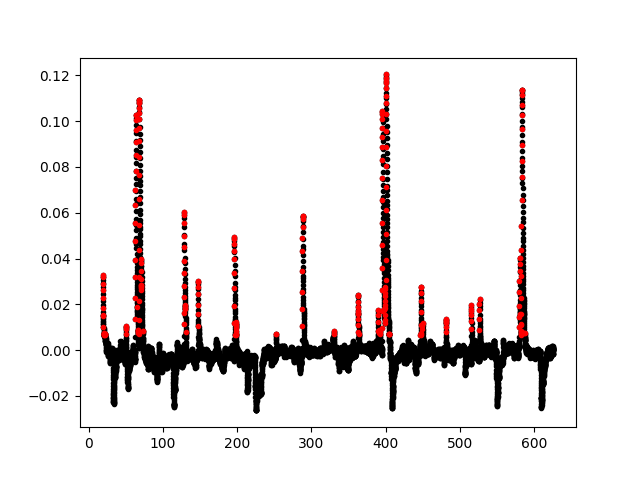

In [11]:
# # play with z_threshold just to decide which one is the best for your data

signal_type = 'Binarized'
sampling_rate = 1 / np.nanmean(np.diff(time_vector))
input_signal = hf.preprocess_signal(signal_norm,sampling_rate,signal_type,z_threshold = 0.5)

plt.figure()
plt.plot(time_vector,signal_norm,'k.')
plt.plot(time_vector[input_signal==1],signal_norm[input_signal==1],'r.')
# plt.plot(time_vector[input_signal==1],signal_norm[input_signal==1],'r.')
# plt.plot(time_vector,input_signal,'r.')
plt.show()


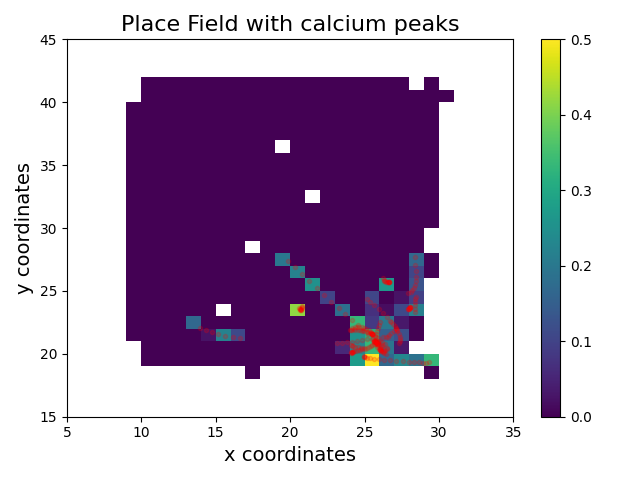

In [3]:

plt.figure()
# plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map'],shading = 'auto',edgecolors=None)
# plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors='red')
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors=None)
plt.colorbar()
plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)

plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



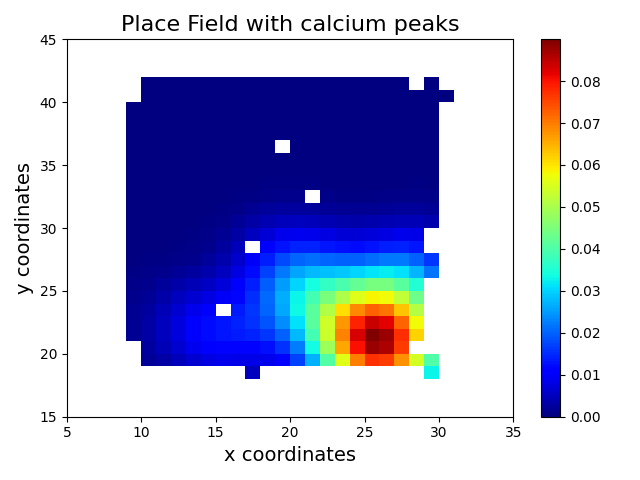

In [15]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map_smoothed'],edgecolors=None,cmap='jet')

# plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



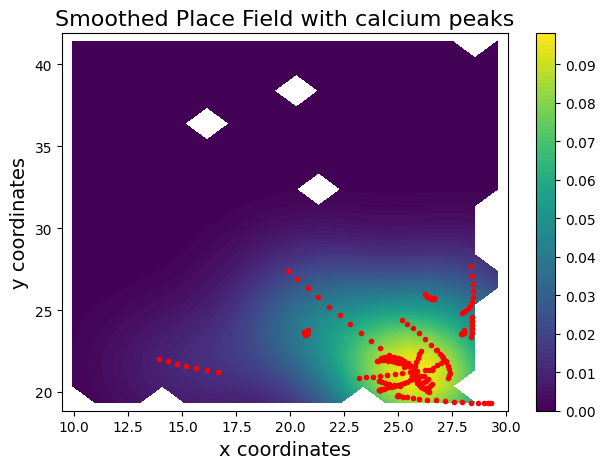

In [26]:

plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'],100,cmap='viridis')
plt.plot(spatial_metrics_output['peaks_x_location'],spatial_metrics_output['peaks_y_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([data_info.environment_edges[0][0],data_info.environment_edges[0][1]])
plt.ylim([data_info.environment_edges[1][0],data_info.environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



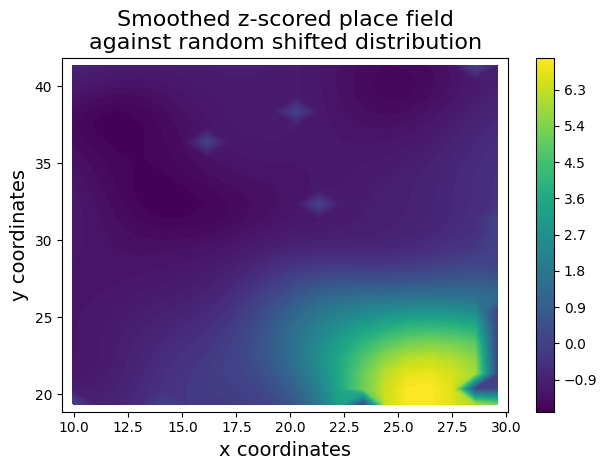

In [29]:

mean_activity_map_shifted = np.nanmean(spatial_metrics_output['activity_map_smoothed_shifted'],0)
std_activity_map_shifted = np.nanstd(spatial_metrics_output['activity_map_smoothed_shifted'],0)
activity_map_smoothed = spatial_metrics_output['activity_map_smoothed'].copy()
activity_map_smoothed_zscored = (activity_map_smoothed - mean_activity_map_shifted)/std_activity_map_shifted

nan_mask = np.isnan(activity_map_smoothed_zscored)
activity_map_smoothed_zscored[nan_mask] = 0

plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],activity_map_smoothed_zscored,100)
plt.colorbar()
plt.title('Smoothed z-scored place field\nagainst random shifted distribution',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([data_info.environment_edges[0][0],data_info.environment_edges[0][1]])
plt.ylim([data_info.environment_edges[1][0],data_info.environment_edges[1][1]])
plt.tight_layout()
plt.show()


array([0.10434783, 0.        ])

array([0.10859729, 0.        ])

In [12]:
spatial_metrics_output.keys()


dict_keys(['activity_map', 'activity_map_smoothed', 'activity_map_shifted', 'activity_map_smoothed_shifted', 'timespent_map', 'visits_map', 'speed_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'activity_map_identity', 'num_of_fields', 'fields_x_max', 'fields_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shifted', 'mutual_info_zscored', 'mutual_info_centered', 'input_parameters'])

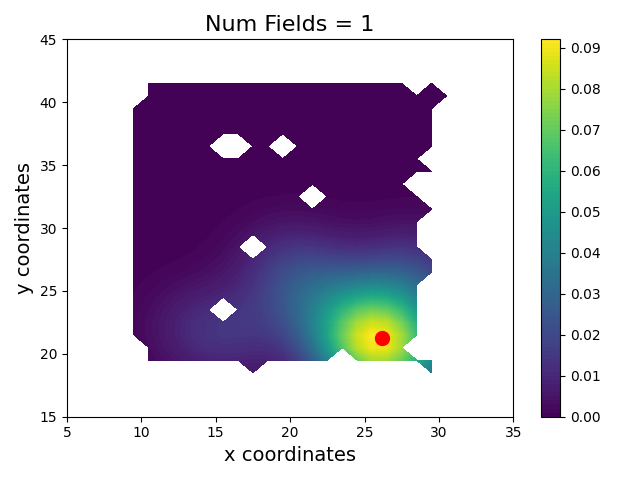

In [9]:
activity_map_x_center_coord = spatial_metrics_output['fields_x_max']
activity_map_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'],100)
# plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'])
plt.colorbar()
plt.plot(activity_map_x_center_coord,activity_map_y_center_coord,'r.',markersize=20)

plt.title('Num Fields = {0}'.format(spatial_metrics_output['num_of_fields']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


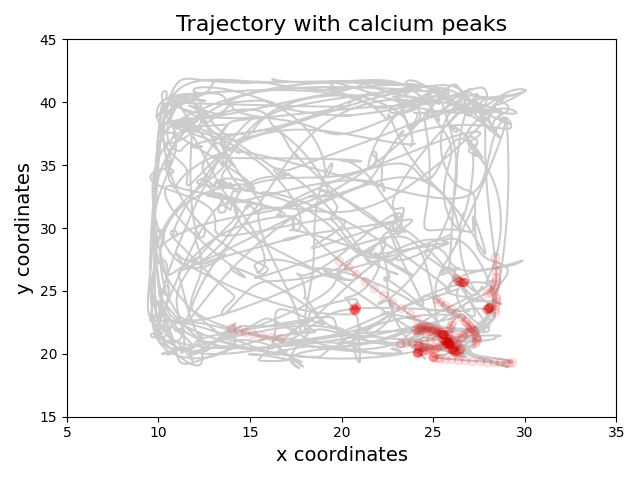

In [41]:

x_peaks_location = spatial_metrics_output['x_peaks_location']
y_peaks_location = spatial_metrics_output['y_peaks_location']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


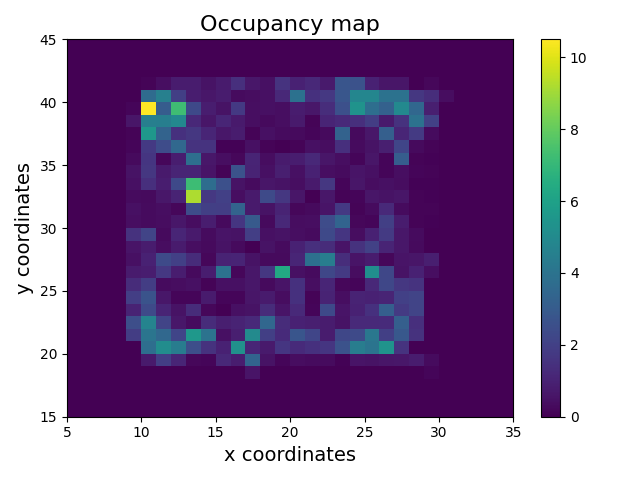

In [42]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['timespent_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


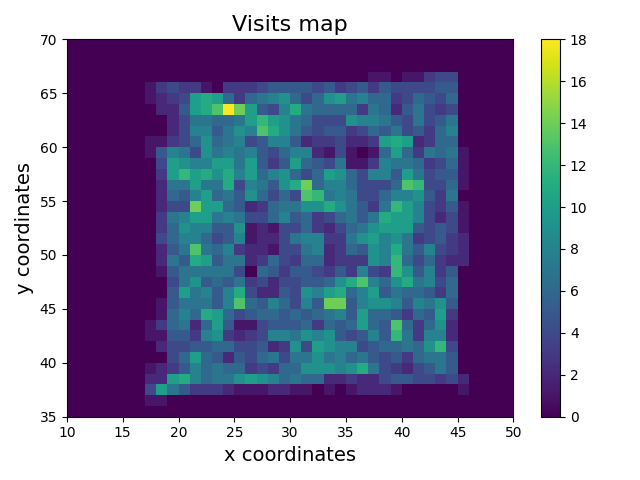

In [107]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


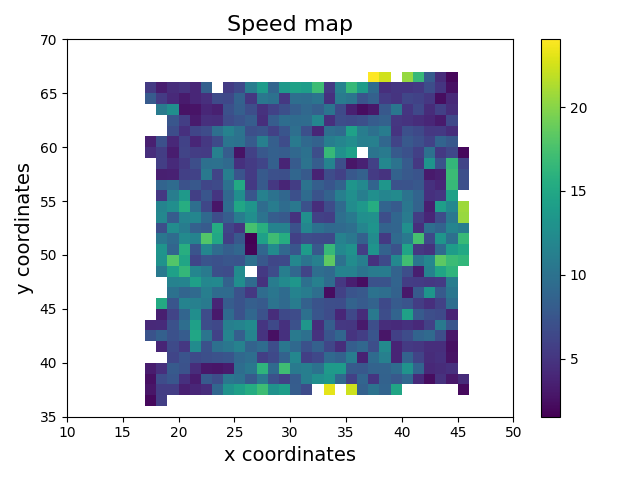

In [108]:


plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['speed_map'])
plt.colorbar()
plt.title('Speed map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()
